# Week 9 - Multivariate Analysis, part 2

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [2]:
# Load dataset

import kagglehub
import os

# Download latest version

path = kagglehub.dataset_download("mrwellsdavid/unsw-nb15")

filename = "UNSW_NB15_training-set.csv"

csv_path = os.path.join(path, filename)
df = pd.read_csv(csv_path)

100%|██████████| 149M/149M [00:00<00:00, 195MB/s]

Extracting files...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [4]:
pd.set_option('display.max_columns', None)
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0


In [5]:
descriptions = pd.DataFrame({
    'dur' : ['Record total duration'],
    'proto' : ['Transaction protocol'],
    'service' : ['http, ftp, smtp, ssh, dns, ftp-data ,irc and (-) if not much used service'],
    'state' : ['Indicates to the state and its dependent protocol, e.g. ACC, CLO, CON, ECO, ECR, FIN, INT, MAS, PAR,...'],
    'spkts' : ['Source to destination packet count'],
    'dpkts' : ['Destination to source packet count'],
    'sbytes' : ['Source to destination transaction bytes'],
    'dbytes' : ['Destination to source transaction bytes'],
    'sttl' : ['Source to destination time to live value'],
    'dttl' : ['Destination to source time to live value'],
    'sload' : ['Source bits per second'],
    'dload' : ['Destination bits per second'],
    'sloss' : ['Source packets retransmitted or dropped'],
    'dloss' : ['Destination packets retransmitted or dropped'],
    'sinpkt' : ['Source interpacket arrival time (mSec)'],
    'dinpkt' : ['Destination interpacket arrival time (mSec)'],
    'sjit' : ['Source jitter (mSec)'],
    'djit' : ['Destination jitter (mSec)'],
    'swin' : ['Source TCP window advertisement value'],
    'dtcpb' : ['Destination TCP base sequence number'],
    'dwin' : ['Destination TCP window advertisement value'],
    'tcprtt' : ['TCP connection setup round-trip time, the sum of synack and ackdat.'],
    'synack' : ['TCP connection setup time, the time between the SYN and the SYN_ACK packets.'],
    'ackdat' : ['TCP connection setup time, the time between the SYN_ACK and the ACK packets.'],
    'smean' : ['Mean of the flow packet size transmitted by the src'],
    'dmean' : ['Mean of the flow packet size transmitted by the dst'],
    'trans_depth' : ['Represents the pipelined depth into the connection of http request/response transaction'],
    'response_body_len' : ['Actual uncompressed content size of the data transferred from the server’s http service.'],
    'ct_srv_src' : ['No. of connections that contain the same service and source address in 100 connections.'],
    'ct_state_ttl' : ['No. for each state according to TTL values in 100 connections.'],
    'ct_dst_ltm' : ['No. of connections of the same destination address in 100 recent connections.'],
    'ct_src_dport_ltm' : ['No. of connections of the same source and destination port in 100 connections.'],
    'ct_dst_sport_ltm' : ['No. of connections of the same destination and source port in 100 connections.'],
    'ct_dst_src_ltm' : ['No. of connections of the same source and destination address in 100 connections.'],
    'is_ftp_login' : ['1 if ftp session is accessed by user and password, else 0.'],
    'ct_ftp_cmd' : ['No of flows with an ftp command.'],
    'ct_flw_http_mthd' : ['No. of flows with HTTP methods like GET or POST.'],
    'ct_src_ltm' : ['No. of connections of the same source address in 100 recent connections.'],
    'ct_srv_dst' : ['No. of connections with the same service and destination address in 100 connections.'],
    'is_sm_ips_ports' : ['1 if source and destination IPs and ports are equal, else 0.'],
    'attack_cat' : ['Name of attack category (e.g., Fuzzers, Backdoor, etc.)'],
    'label' : ['0 for normal, 1 for attack records']
}, index=['Description']).T

descriptions

,Description
dur,Record total duration
proto,Transaction protocol
service,"http, ftp, smtp, ssh, dns, ftp-data ,irc and (..."
state,Indicates to the state and its dependent proto...
spkts,Source to destination packet count
dpkts,Destination to source packet count
sbytes,Source to destination transaction bytes
dbytes,Destination to source transaction bytes
sttl,Source to destination time to live value
dttl,Destination to source time to live value


In [6]:
# Turn the categorical features into numerical features (proto, service, state, attack_cat)

df_gd = df.copy()

# One-hot encoding

proto_gd = pd.get_dummies(df_gd['proto'], prefix='proto')
service_gd = pd.get_dummies(df_gd['service'], prefix='service')
state_gd = pd.get_dummies(df_gd['state'], prefix='state')
attack_type = pd.get_dummies(df_gd['attack_cat'], prefix='attack_cat')

dummy_df = pd.concat([proto_gd, service_gd, state_gd, attack_type], axis=1)

df_gd = df_gd.drop(['proto', 'service', 'state', 'attack_cat'], axis=1)

new_df_gd = pd.concat([df_gd, dummy_df], axis=1)

new_df_gd.head()


,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,proto_br-sat-mon,proto_cbt,proto_cftp,proto_chaos,proto_compaq-peer,proto_cphb,proto_cpnx,proto_crtp,proto_crudp,proto_dcn,proto_ddp,proto_ddx,proto_dgp,proto_egp,proto_eigrp,proto_emcon,proto_encap,proto_etherip,proto_fc,proto_fire,proto_ggp,proto_gmtp,proto_gre,proto_hmp,proto_i-nlsp,proto_iatp,proto_ib,proto_idpr,proto_idpr-cmtp,proto_idrp,proto_ifmp,proto_igmp,proto_igp,proto_il,proto_ip,proto_ipcomp,proto_ipcv,proto_ipip,proto_iplt,proto_ipnip,proto_ippc,proto_ipv6,proto_ipv6-frag,proto_ipv6-no,proto_ipv6-opts,proto_ipv6-route,proto_ipx-n-ip,proto_irtp,proto_isis,proto_iso-ip,proto_iso-tp4,proto_kryptolan,proto_l2tp,proto_larp,proto_leaf-1,proto_leaf-2,proto_merit-inp,proto_mfe-nsp,proto_mhrp,proto_micp,proto_mobile,proto_mtp,proto_mux,proto_narp,proto_netblt,proto_nsfnet-igp,proto_nvp,proto_ospf,proto_pgm,proto_pim,proto_pipe,proto_pnni,proto_pri-enc,proto_prm,proto_ptp,proto_pup,proto_pvp,proto_qnx,proto_rdp,proto_rsvp,proto_rvd,proto_sat-expak,proto_sat-mon,proto_sccopmce,proto_scps,proto_sctp,proto_sdrp,proto_secure-vmtp,proto_sep,proto_skip,proto_sm,proto_smp,proto_snp,proto_sprite-rpc,proto_sps,proto_srp,proto_st2,proto_stp,proto_sun-nd,proto_swipe,proto_tcf,proto_tcp,proto_tlsp,proto_tp++,proto_trunk-1,proto_trunk-2,proto_ttp,proto_udp,proto_unas,proto_uti,proto_vines,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero,service_-,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_ACC,state_CLO,state_CON,state_FIN,state_INT,state_REQ,state_RST,attack_cat_Analysis,attack_cat_Backdoor,attack_cat_DoS,attack_cat_Exploits,attack_cat_Fuzzers,attack_cat_Generic,attack_cat_Normal,attack_cat_Reconnaissance,attack_cat_Shellcode,attack_cat_Worms
0,1,0.000011,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
1,2,0.000008,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [7]:
# Heatmap of all features

all_corr = new_df_gd.corr()

plt.figure(figsize=(100,98))
sns.heatmap(all_corr, cmap='coolwarm', annot=False, linewidth=0.1, linecolor='black')
plt.show()

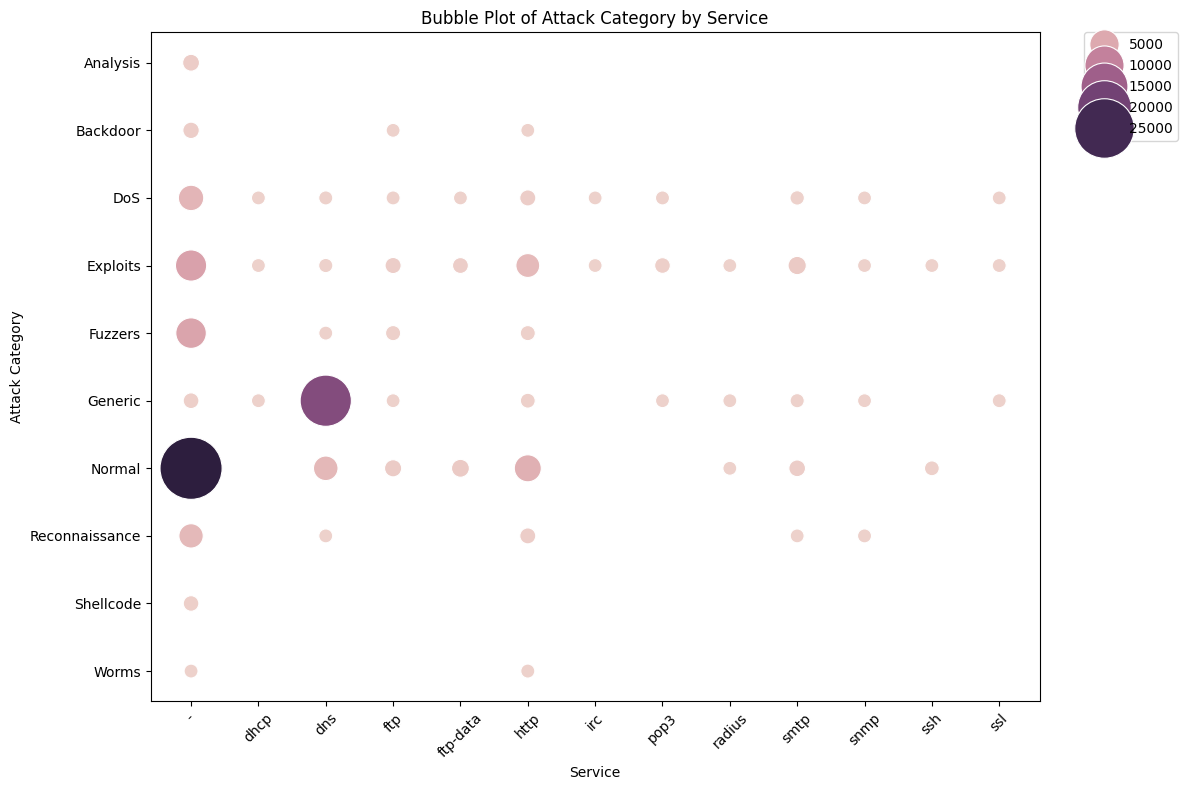

In [8]:
# Bubble Plot

bubble_df = df.groupby(['service', 'attack_cat']).size().reset_index(name='count')

plt.figure(figsize=(12,8))
bubble_plot = sns.scatterplot(
    data=bubble_df,
    x='service',
    y='attack_cat',
    size='count',
    sizes=(100, 2000),
    hue='count',
    legend='brief'
)

plt.xticks(rotation=45)
plt.title('Bubble Plot of Attack Category by Service')
plt.xlabel('Service')
plt.ylabel('Attack Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

The goal of this bubble plot is to visualize the frequency of different attack categories (attack_cat) across various network services (service) in the UNSW-NB15 dataset. By grouping data on both dimensions and using bubble size and color to represent the count, the plot highlights which service-attack combinations are most prevalent.

The bubble plot shows that the dataset is heavily dominated by a few specific service-attack combinations. The most prominent is Normal traffic over the undefined service represented by - , followed by Normal traffic over the dns service. Additionally, Generic attacks occurring over the dns service also appear in high volume. These three combinations: Normal over - , Normal over dns, and Generic over dns—stand out with significantly larger and darker bubbles, indicating they contribute the bulk of the observations in the dataset. All other combinations are present in much smaller frequencies by comparison.

In [9]:
df_enc = new_df_gd.drop(columns=['label'])

scaler = StandardScaler()
df_enc_scaled = scaler.fit_transform(df_enc)

pca = PCA(n_components=30)
pca_result = pca.fit_transform(df_enc_scaled)

components = pca.components_
print(f"PCA Component 1:\n{components[0]}")
print(f"\nPCA Component 2:\n{components[1]}")
print(f"\nPCA Component 3:\n{components[2]}")

explained_variance = pca.explained_variance_ratio_
print("\nExplained variance ratios:", explained_variance)
print("Total explained variance:", explained_variance.sum())


PCA Component 1:
[ 0.08021454  0.03501807  0.03629019  0.0460156   0.01742719  0.03106953
 -0.16306973 -0.12408748  0.19668278 -0.08960393  0.05488078  0.02374465
  0.03689015  0.00060728  0.02395181  0.03174559  0.04121286  0.234975
  0.18990388  0.18932575  0.23730029  0.13206042  0.11436509  0.13102652
  0.0506037   0.11119902  0.0480773   0.01602974 -0.20921263 -0.12810533
 -0.1939939  -0.20243572 -0.20333503 -0.20337247  0.02393852  0.02384006
  0.05615545 -0.19514235 -0.21185916 -0.00237052 -0.0025685  -0.00348362
 -0.00237541 -0.00514019 -0.00438683 -0.00220648 -0.0018344  -0.00262033
 -0.00475013 -0.00269156 -0.00239289 -0.00313765 -0.00274655 -0.00467416
 -0.00243352 -0.0028283  -0.00283488 -0.0030942  -0.00293054 -0.00252908
 -0.00284319 -0.00300331 -0.00258168 -0.0035703  -0.00303274 -0.0042961
 -0.00273981 -0.00319031 -0.00254898 -0.00392427 -0.0025362  -0.00283592
 -0.00449956 -0.00244863 -0.0023035  -0.0028391  -0.00254161 -0.00301453
 -0.00299602 -0.00330107 -0.00305546 

This dataset contains a large number of features, including both numeric metrics and one-hot encoded categorical variables, many of which are sparse or weakly correlated. Thus, the variance is thinly spread across a high number of dimensions, rather than concentrated in a few. Which explains the first 30 principal components capturing only around 31.5% of the total variance and reflects the dataset's complexity. This outcome suggests that the patterns distinguishing different types of traffic—especially subtle differences between normal and attack behaviors—are distributed across many features, requiring more components to retain meaningful information. For intrusion detection tasks, this reinforces the importance of either retaining a larger number of components or combining PCA with other feature engineering techniques to ensure critical patterns aren't lost.

In [10]:
# Logistic Regression

X = new_df_gd[[
    'rate', 'sttl', 'swin', 'dwin', 'ct_state_ttl',
    'ct_src_dport_ltm', 'ct_dst_sport_ltm',
    'proto_tcp', 'service_dns', 'state_CON', 'state_FIN', 'state_INT'
]]

y = new_df_gd['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(max_iter=2000, solver='liblinear')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8085868707111192

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.63      0.75      7400
           1       0.76      0.96      0.85      9067

    accuracy                           0.81     16467
   macro avg       0.84      0.79      0.80     16467
weighted avg       0.83      0.81      0.80     16467


Confusion Matrix:
 [[4642 2758]
 [ 394 8673]]


The logistic regression model achieved an accuracy of approximately 80.9%, indicating solid overall performance. It demonstrated strong ability to detect attack traffic (class 1), with a recall of 0.96, meaning it successfully identified 96% of all actual attacks. However, this came at the cost of some misclassification of normal traffic (class 0), which had a lower recall of 0.63, meaning 37% of normal instances were incorrectly flagged as attacks. Precision for class 0 was high (0.92), reflecting that most traffic predicted as normal was indeed normal. The confusion matrix shows that only 394 attacks were missed, while 2,758 normal records were falsely flagged as attacks. This recall-heavy behavior is desirable in security settings, where catching as many attacks as possible is critical. Overall, the model performs well for a baseline, especially in prioritizing detection of malicious traffic.

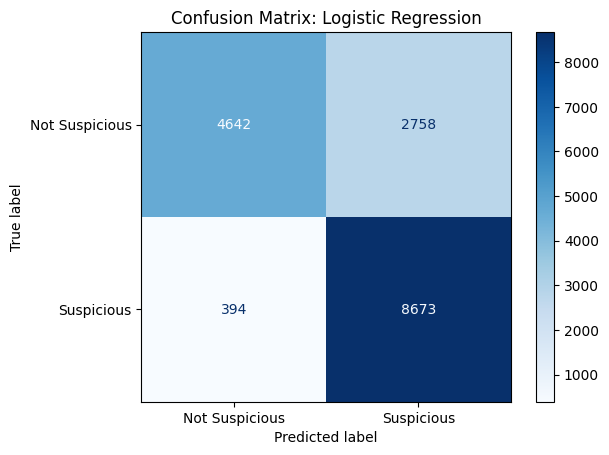

In [11]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Suspicious', 'Suspicious'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

In [13]:
X = new_df_gd[[
    'rate', 'sttl', 'swin', 'dwin', 'ct_state_ttl',
    'ct_src_dport_ltm', 'ct_dst_sport_ltm',
    'proto_tcp', 'service_dns', 'state_CON', 'state_FIN', 'state_INT'
]]
y = new_df_gd['label']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_estimators': [195],
    'max_depth': [30],
    'max_features': [0.8],
    'bootstrap': [False]
}


modelrf = RandomForestClassifier(random_state=42)

randsearchcv = RandomizedSearchCV(
    estimator=modelrf,
    param_distributions=param_grid,
    n_iter=1,
    cv=5,
    random_state=42,
    n_jobs=-1
)

randsearchcv.fit(X_train_scaled, y_train)

print("Best Parameters:", randsearchcv.best_params_)
print("Best Cross-Val Score:", randsearchcv.best_score_)

Best Parameters: {'n_estimators': 195, 'max_features': 0.8, 'max_depth': 30, 'bootstrap': False}
Best Cross-Val Score: 0.8559781370986108


The Random Forest model achieved a strong cross-validation score of 85.6%, outperforming the logistic regression model, which had an accuracy of approximately 80.9%. While logistic regression favored recall for detecting attacks (0.96), it had limitations in capturing complex, non-linear patterns. In contrast, Random Forest leverages multiple decision trees and feature interactions, allowing it to generalize better and more accurately classify both normal and attack traffic. Its higher accuracy and robustness mean it's better equipped to detect malicious network activity in real-world settings.

In [15]:
X = new_df_gd[[
    'rate', 'sttl', 'swin', 'dwin', 'ct_state_ttl',
    'ct_src_dport_ltm', 'ct_dst_sport_ltm',
    'proto_tcp', 'service_dns', 'state_CON', 'state_FIN', 'state_INT'
]]
y = new_df_gd['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lgbm = LGBMClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'learning_rate': [0.05, 0.1]
}

grid = GridSearchCV(lgbm, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

y_pred = grid.predict(X_test_scaled)

print("Best Parameters:", grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 36265, number of negative: 29600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 65865, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550596 -> initscore=0.203079
[LightGBM] [Info] Start training from score 0.203079
Best Parameters: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200}
Accuracy: 0.8670067407542358

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      7400
           1       0.89      0.87      0.88      9067

    accuracy                           0.87     16467
   macro avg       0.87      0.87      0.87     16467
weighted avg       0.87      0.87      0.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


The LightGBM model delivered the strongest performance among all models tested so far, achieving an overall accuracy of 86.7%. It demonstrated a balanced and reliable classification of both normal and suspicious network traffic, with precision and recall scores hovering between 0.84 and 0.89 for both classes. Unlike the logistic regression model—which favored attack detection but struggled with normal traffic—and the Random Forest model, which slightly underperformed LightGBM, this model maintained consistent F1-scores of 0.87 for both classes. The confusion matrix confirms this balance, showing that LightGBM effectively reduces both false positives and false negatives. These results indicate that LightGBM captures complex patterns in network behavior while minimizing overfitting. For the overall project goal of building a dependable intrusion detection system, this model offers the best trade-off so far between sensitivity to attacks and accurate recognition of normal traffic—moving the system closer to being both effective and trustworthy in a real-world deployment.

In [16]:
model_comparison = {
    'Model': ['Logistic Regression', 'Random Forest', 'LightGBM'],
    'Type': ['Supervised', 'Supervised', 'Supervised'],
    'Use Case': [
        'Baseline classifier with strong recall on attacks',
        'Non-linear learner capturing threat patterns',
        'Best overall performance; production-ready IDS'
    ],
    'Model Ranking': ['3rd', '2nd', '1st']
}

unsw_models = pd.DataFrame(model_comparison)
display(unsw_models)

,Model,Type,Use Case,Model Ranking
0,Logistic Regression,Supervised,Baseline classifier with strong recall on attacks,3rd
1,Random Forest,Supervised,Non-linear learner capturing threat patterns,2nd
2,LightGBM,Supervised,Best overall performance; production-ready IDS,1st
